In [6]:

import os
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
from tqdm import tqdm
from ultralytics import YOLO  # Ensure you have `pip install ultralytics`
import random


# --- CONFIG ---
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}") 
BASE_DATA_ROOT = "../soccernet_data/tracking"
GT_FILENAME = "gt.txt"
IMAGE_FOLDER = "img1"
IMAGE_EXTS = ['.jpg', '.png']
NUM_VISUALS = 10
SCORE_THRESH = 0.8
IOU_THRESH = 0.5
SAMPLE_PER_SEQ = 30

Using device: mps


Using device: mps
Processing sequences...


Sequences:   0%|          | 0/106 [00:00<?, ?it/s]


0: 384x640 17 persons, 755.1ms
Speed: 19.2ms preprocess, 755.1ms inference, 217.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 persons, 16.7ms
Speed: 2.1ms preprocess, 16.7ms inference, 101.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 1 sports ball, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 69.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.7ms
Speed: 2.1ms preprocess, 15.7ms inference, 99.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.1ms
Speed: 2.3ms preprocess, 16.1ms inference, 36.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.6ms
Speed: 2.2ms preprocess, 15.6ms inference, 100.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 1 sports ball, 15.4ms
Speed: 2.1ms preprocess, 15.4ms inference, 99.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4m

Sequences:   1%|          | 1/106 [00:10<17:30, 10.00s/it]


0: 384x640 9 persons, 30.8ms
Speed: 3.2ms preprocess, 30.8ms inference, 101.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.2ms
Speed: 2.2ms preprocess, 15.2ms inference, 8.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 17.4ms
Speed: 2.5ms preprocess, 17.4ms inference, 74.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 18.7ms
Speed: 2.0ms preprocess, 18.7ms inference, 74.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 sports ball, 19.0ms
Speed: 2.2ms preprocess, 19.0ms inference, 105.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 sports ball, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 10.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 17.1ms
Speed: 2.4ms preprocess, 17.1ms inference, 74.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 16.8ms
Speed: 2.7ms preprocess, 16.8ms infer

Sequences:   2%|▏         | 2/106 [00:15<13:06,  7.56s/it]


0: 384x640 14 persons, 30.4ms
Speed: 2.6ms preprocess, 30.4ms inference, 14.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.6ms
Speed: 2.5ms preprocess, 15.6ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.4ms
Speed: 2.1ms preprocess, 16.4ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.2ms
Speed: 2.3ms preprocess, 15.2ms inference, 14.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.4ms
Speed: 2.2ms preprocess, 15.4ms inference, 9.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 persons, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 104.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.7ms
Speed: 1.9ms preprocess, 15.7ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.6ms
Speed: 2.5ms preprocess, 15.6ms inference, 72.4ms postprocess per i

Sequences:   3%|▎         | 3/106 [00:21<11:30,  6.70s/it]


0: 384x640 7 persons, 31.8ms
Speed: 2.4ms preprocess, 31.8ms inference, 98.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.1ms
Speed: 2.2ms preprocess, 15.1ms inference, 77.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 17.7ms
Speed: 2.0ms preprocess, 17.7ms inference, 74.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.4ms
Speed: 2.1ms preprocess, 15.4ms inference, 9.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 75.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 16.1ms
Speed: 2.3ms preprocess, 16.1ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 74.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.0ms
Speed: 2.1ms preprocess, 15.0ms inference, 76.8ms postprocess per im

Sequences:   4%|▍         | 4/106 [00:27<10:36,  6.24s/it]


0: 384x640 13 persons, 31.0ms
Speed: 2.4ms preprocess, 31.0ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.7ms
Speed: 1.9ms preprocess, 15.7ms inference, 73.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 34.1ms
Speed: 2.6ms preprocess, 34.1ms inference, 9.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 470.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 14.9ms
Speed: 2.3ms preprocess, 14.9ms inference, 79.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 16.7ms
Speed: 2.2ms preprocess, 16.7ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.9ms
Speed: 3.6ms preprocess, 15.9ms inference, 59.1ms postprocess per 

Sequences:   5%|▍         | 5/106 [00:33<10:39,  6.33s/it]


0: 384x640 20 persons, 32.0ms
Speed: 2.4ms preprocess, 32.0ms inference, 14.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 77.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 16.2ms
Speed: 2.0ms preprocess, 16.2ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.3ms
Speed: 2.1ms preprocess, 15.3ms inference, 13.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 35.3ms
Speed: 2.2ms preprocess, 35.3ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.5ms
Speed: 2.4ms preprocess, 15.5ms inference, 13.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.3ms
Speed: 2.2ms preprocess, 15.3ms inference, 78.1ms postprocess per 

Sequences:   6%|▌         | 6/106 [00:39<10:18,  6.19s/it]


0: 384x640 17 persons, 44.5ms
Speed: 2.5ms preprocess, 44.5ms inference, 17.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 16.5ms
Speed: 6.1ms preprocess, 16.5ms inference, 85.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 20.0ms
Speed: 2.7ms preprocess, 20.0ms inference, 15.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 17.6ms
Speed: 2.4ms preprocess, 17.6ms inference, 14.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 16.7ms
Speed: 2.6ms preprocess, 16.7ms inference, 89.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 17.9ms
Speed: 3.1ms preprocess, 17.9ms inference, 17.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 17.2ms
Speed: 2.0ms preprocess, 17.2ms inference, 14.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 18.6ms
Speed: 2.0ms preprocess, 18.6ms inference, 15.7ms postprocess per i

Sequences:   7%|▋         | 7/106 [00:45<10:06,  6.12s/it]


0: 384x640 11 persons, 33.9ms
Speed: 2.4ms preprocess, 33.9ms inference, 86.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 25 persons, 15.7ms
Speed: 2.3ms preprocess, 15.7ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 17.2ms
Speed: 2.4ms preprocess, 17.2ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 18.4ms
Speed: 2.2ms preprocess, 18.4ms inference, 17.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 16.1ms
Speed: 2.4ms preprocess, 16.1ms inference, 80.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.4ms
Speed: 2.2ms preprocess, 15.4ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 1 sports ball, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 14.3ms p

Sequences:   8%|▊         | 8/106 [00:51<09:53,  6.06s/it]


0: 384x640 11 persons, 102.6ms
Speed: 2.0ms preprocess, 102.6ms inference, 28.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 sports ball, 16.3ms
Speed: 2.0ms preprocess, 16.3ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 sports ball, 21.5ms
Speed: 5.4ms preprocess, 21.5ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 12.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 sports ball, 16.9ms
Speed: 2.5ms preprocess, 16.9ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 17.8ms
Speed: 3.0ms preprocess, 17.8ms inference, 10.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 sports ball, 16.1ms
Speed: 2.6ms preprocess, 16.1ms inference, 22.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 16.6ms
Spee

Sequences:   8%|▊         | 9/106 [00:56<09:24,  5.82s/it]


0: 384x640 17 persons, 32.0ms
Speed: 2.4ms preprocess, 32.0ms inference, 11.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.9ms
Speed: 1.8ms preprocess, 15.9ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 16.5ms
Speed: 2.5ms preprocess, 16.5ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 18.0ms
Speed: 2.1ms preprocess, 18.0ms inference, 9.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.3ms
Speed: 2.3ms preprocess, 16.3ms inference, 9.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 16.8ms
Speed: 2.1ms preprocess, 16.8ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 24.2ms
Speed: 2.1ms preprocess, 24.2ms inference, 15.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 22.9ms
Speed: 2.6ms preprocess, 22.9ms inference, 13.9ms postprocess per im

Sequences:   9%|▉         | 10/106 [01:01<08:55,  5.58s/it]


0: 384x640 12 persons, 32.7ms
Speed: 2.8ms preprocess, 32.7ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 15.7ms
Speed: 2.3ms preprocess, 15.7ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 1 sports ball, 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.6ms
Speed: 2.3ms preprocess, 15.6ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.4ms
Speed: 1.8ms preprocess, 16.4ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 17.8ms
Speed: 2.0ms preprocess, 17.8ms inference, 14.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 14.4ms po

Sequences:  10%|█         | 11/106 [01:06<08:20,  5.26s/it]


0: 384x640 14 persons, 30.6ms
Speed: 2.2ms preprocess, 30.6ms inference, 80.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.7ms
Speed: 2.1ms preprocess, 15.7ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.6ms
Speed: 1.8ms preprocess, 15.6ms inference, 87.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.7ms
Speed: 2.1ms preprocess, 15.7ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 16.6ms
Speed: 2.0ms preprocess, 16.6ms inference, 12.5ms postprocess per i

Sequences:  11%|█▏        | 12/106 [01:11<08:10,  5.21s/it]


0: 384x640 17 persons, 30.7ms
Speed: 2.2ms preprocess, 30.7ms inference, 7.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 16.1ms
Speed: 1.8ms preprocess, 16.1ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 12.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.3ms
Speed: 1.9ms preprocess, 15.3ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.6ms
Speed: 2.2ms preprocess, 15.6ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.1ms
Speed: 2.2ms preprocess, 15.1ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 13.4ms postprocess per ima

Sequences:  12%|█▏        | 13/106 [01:15<07:47,  5.03s/it]


0: 384x640 14 persons, 33.0ms
Speed: 2.6ms preprocess, 33.0ms inference, 14.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 16.1ms
Speed: 2.3ms preprocess, 16.1ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.0ms
Speed: 2.6ms preprocess, 15.0ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 sports ball, 14.7ms
Speed: 2.1ms preprocess, 14.7ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.1ms
Speed: 2.1ms preprocess, 15.1ms inference, 12.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.2ms
Speed: 2.2ms preprocess, 15.2ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 12.7ms po

Sequences:  13%|█▎        | 14/106 [01:20<07:35,  4.95s/it]


0: 384x640 17 persons, 30.3ms
Speed: 2.6ms preprocess, 30.3ms inference, 7.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.2ms
Speed: 1.6ms preprocess, 15.2ms inference, 8.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.8ms
Speed: 1.7ms preprocess, 15.8ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.1ms
Speed: 2.0ms preprocess, 15.1ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 15.2ms
Speed: 2.1ms preprocess, 15.2ms inference, 13.3ms postprocess per image

Sequences:  14%|█▍        | 15/106 [01:25<07:37,  5.03s/it]


0: 384x640 13 persons, 31.1ms
Speed: 2.4ms preprocess, 31.1ms inference, 11.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.4ms
Speed: 2.1ms preprocess, 15.4ms inference, 13.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.2ms
Speed: 2.1ms preprocess, 15.2ms inference, 13.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 13.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 88.9ms postprocess per i

Sequences:  15%|█▌        | 16/106 [01:31<07:33,  5.04s/it]


0: 384x640 17 persons, 30.5ms
Speed: 2.5ms preprocess, 30.5ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 15.3ms
Speed: 2.1ms preprocess, 15.3ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 persons, 15.7ms
Speed: 1.9ms preprocess, 15.7ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 12.5ms postprocess per i

Sequences:  16%|█▌        | 17/106 [01:36<07:52,  5.31s/it]


0: 384x640 25 persons, 1 sports ball, 32.3ms
Speed: 2.4ms preprocess, 32.3ms inference, 95.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 16.9ms
Speed: 2.4ms preprocess, 16.9ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 16.4ms
Speed: 2.3ms preprocess, 16.4ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 persons, 1 sports ball, 15.7ms
Speed: 1.8ms preprocess, 15.7ms inference, 95.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 persons, 16.1ms
Speed: 2.4ms preprocess, 16.1ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 9.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 15.7ms
Speed: 3.0ms preprocess, 15.7ms inference, 14.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 16.0ms
Speed: 2.1ms preprocess, 16.0ms infere

Sequences:  17%|█▋        | 18/106 [01:42<08:00,  5.46s/it]


0: 384x640 12 persons, 34.7ms
Speed: 2.4ms preprocess, 34.7ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.7ms
Speed: 2.2ms preprocess, 15.7ms inference, 14.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 car, 16.1ms
Speed: 2.0ms preprocess, 16.1ms inference, 12.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 7.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 17.6ms
Speed: 2.8ms preprocess, 17.6ms inference, 14.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 12.8ms postproces

Sequences:  18%|█▊        | 19/106 [01:47<07:36,  5.24s/it]


0: 384x640 10 persons, 30.8ms
Speed: 2.2ms preprocess, 30.8ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 16.7ms
Speed: 1.8ms preprocess, 16.7ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.7ms
Speed: 2.4ms preprocess, 15.7ms inference, 7.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 14.8ms
Speed: 2.1ms preprocess, 14.8ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.0ms
Speed: 2.5ms preprocess, 15.0ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 14.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 16.0ms
Speed: 2.4ms preprocess, 16.0ms inference, 12.8ms postprocess per imag

Sequences:  19%|█▉        | 20/106 [01:51<07:05,  4.95s/it]


0: 384x640 11 persons, 30.6ms
Speed: 2.8ms preprocess, 30.6ms inference, 8.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.9ms
Speed: 2.5ms preprocess, 15.9ms inference, 12.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.5ms
Speed: 2.3ms preprocess, 15.5ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.6ms
Speed: 2.2ms preprocess, 15.6ms inference, 96.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.6ms
Speed: 2.8ms preprocess, 15.6ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.1ms
Speed: 2.3ms preprocess, 16.1ms inference, 8.8ms postprocess per image

Sequences:  20%|█▉        | 21/106 [01:56<06:43,  4.74s/it]


0: 384x640 9 persons, 30.7ms
Speed: 2.3ms preprocess, 30.7ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.2ms
Speed: 2.1ms preprocess, 15.2ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.0ms
Speed: 1.9ms preprocess, 15.0ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 9.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 sports ball, 14.8ms
Speed: 2.4ms preprocess, 14.8ms inference, 11.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 8.3ms postpr

Sequences:  21%|██        | 22/106 [02:00<06:29,  4.64s/it]


0: 384x640 13 persons, 102.9ms
Speed: 2.2ms preprocess, 102.9ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.7ms
Speed: 2.1ms preprocess, 15.7ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.9ms
Speed: 2.7ms preprocess, 15.9ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.3ms
Speed: 2.5ms preprocess, 15.3ms inference, 8.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 sports ball, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.1ms
Speed: 2.1ms preprocess, 15.1ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.8ms
Speed: 2.8ms preprocess, 15.8ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 33.4ms
Speed: 2.1ms preprocess, 33.4ms inference, 14.3ms pos

Sequences:  22%|██▏       | 23/106 [02:04<06:05,  4.40s/it]


0: 384x640 15 persons, 31.3ms
Speed: 2.2ms preprocess, 31.3ms inference, 11.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 17.2ms
Speed: 2.4ms preprocess, 17.2ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 16.2ms
Speed: 2.5ms preprocess, 16.2ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 17.5ms
Speed: 2.1ms preprocess, 17.5ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.1ms
Speed: 2.0ms preprocess, 16.1ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 17.2ms
Speed: 2.6ms preprocess, 17.2ms inference, 8.5ms postprocess per i

Sequences:  23%|██▎       | 24/106 [02:08<06:01,  4.41s/it]


0: 384x640 19 persons, 30.3ms
Speed: 2.5ms preprocess, 30.3ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.4ms
Speed: 2.3ms preprocess, 15.4ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.4ms
Speed: 2.1ms preprocess, 15.4ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.2ms
Speed: 2.1ms preprocess, 15.2ms inference, 12.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.6ms
Speed: 3.6ms preprocess, 15.6ms inference, 12.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 17.3ms
Speed: 2.2ms preprocess, 17.3ms inference, 8.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.1ms
Speed: 2.2ms preprocess, 15.1ms inference, 13.3ms postprocess per i

Sequences:  24%|██▎       | 25/106 [02:13<06:09,  4.57s/it]


0: 384x640 11 persons, 30.4ms
Speed: 3.1ms preprocess, 30.4ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.1ms
Speed: 2.0ms preprocess, 15.1ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.4ms
Speed: 2.3ms preprocess, 15.4ms inference, 8.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 8.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 14.3ms
Speed: 2.1ms preprocess, 14.3ms inference, 31.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 12.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.0ms
Speed: 2.2ms preprocess, 15.0ms inference, 12.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 14.4ms
Speed: 1.9ms preprocess, 14.4ms inference, 8.3ms postprocess per image

Sequences:  25%|██▍       | 26/106 [02:18<06:13,  4.67s/it]


0: 384x640 16 persons, 30.7ms
Speed: 2.1ms preprocess, 30.7ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 12.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.2ms
Speed: 2.1ms preprocess, 15.2ms inference, 12.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 14.8ms
Speed: 2.2ms preprocess, 14.8ms inference, 11.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 14.8ms
Speed: 2.0ms preprocess, 14.8ms inference, 7.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 sports ball, 14.7ms
Speed: 1.9ms preprocess, 14.7ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 14.7ms
Speed: 1.9ms preprocess, 14.7ms inference, 12.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 1 sports ball, 14.9ms
Speed: 1.9ms preprocess, 14.9ms infer

Sequences:  25%|██▌       | 27/106 [02:23<06:06,  4.64s/it]


0: 384x640 12 persons, 30.7ms
Speed: 2.5ms preprocess, 30.7ms inference, 92.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.3ms
Speed: 1.9ms preprocess, 15.3ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.4ms
Speed: 2.1ms preprocess, 15.4ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.6ms
Speed: 1.9ms preprocess, 15.6ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 12.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 15.8ms
Speed: 2.4ms preprocess, 15.8ms inference, 13.2ms postprocess per ima

Sequences:  26%|██▋       | 28/106 [02:27<05:56,  4.57s/it]


0: 384x640 19 persons, 31.6ms
Speed: 2.2ms preprocess, 31.6ms inference, 88.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 12.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.3ms
Speed: 2.3ms preprocess, 15.3ms inference, 12.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 16.0ms
Speed: 1.7ms preprocess, 16.0ms inference, 12.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.5ms
Speed: 1.8ms preprocess, 15.5ms inference, 12.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 12.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.1ms
Speed: 2.1ms preprocess, 15.1ms inference, 14.0ms postprocess per ima

Sequences:  27%|██▋       | 29/106 [02:32<05:49,  4.54s/it]


0: 384x640 10 persons, 29.6ms
Speed: 2.6ms preprocess, 29.6ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 12.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 60.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 73.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 16.3ms
Speed: 2.0ms preprocess, 16.3ms inference, 8.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.5ms
Speed: 2.3ms preprocess, 15.5ms inference, 14.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.8ms
Speed: 2.4ms preprocess, 15.8ms inference, 12.3ms postprocess per ima

Sequences:  28%|██▊       | 30/106 [02:36<05:47,  4.57s/it]


0: 384x640 14 persons, 29.2ms
Speed: 2.1ms preprocess, 29.2ms inference, 11.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 11.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 12.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.4ms
Speed: 2.4ms preprocess, 15.4ms inference, 12.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.6ms
Speed: 1.8ms preprocess, 15.6ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 32.2ms
Speed: 1.9ms preprocess, 32.2ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 13.0ms postprocess per i

Sequences:  29%|██▉       | 31/106 [02:41<05:44,  4.59s/it]


0: 384x640 15 persons, 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.4ms
Speed: 1.8ms preprocess, 15.4ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 15.2ms
Speed: 2.4ms preprocess, 15.2ms inference, 61.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.0ms
Speed: 2.3ms preprocess, 16.0ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 32.9ms
Speed: 1.8ms preprocess, 32.9ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 16.1ms
Speed: 2.0ms preprocess, 16.1ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 28.3ms
Speed: 1.8ms preprocess, 28.3ms inference, 15.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.6ms
Speed: 2.3ms preprocess, 15.6ms inference, 14.0ms postprocess per im

Sequences:  30%|███       | 32/106 [02:45<05:40,  4.60s/it]


0: 384x640 16 persons, 32.1ms
Speed: 2.1ms preprocess, 32.1ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 40.8ms
Speed: 2.1ms preprocess, 40.8ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.1ms
Speed: 2.5ms preprocess, 16.1ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 16.3ms
Speed: 2.2ms preprocess, 16.3ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.5ms
Speed: 1.8ms preprocess, 15.5ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 sports ball, 14.8ms
Speed: 2.1ms preprocess, 14.8ms inference, 14.1ms p

Sequences:  31%|███       | 33/106 [02:50<05:29,  4.51s/it]


0: 384x640 15 persons, 31.4ms
Speed: 2.6ms preprocess, 31.4ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 1 sports ball, 15.3ms
Speed: 2.2ms preprocess, 15.3ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 12.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.4ms
Speed: 2.1ms preprocess, 15.4ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 12.7ms postpr

Sequences:  32%|███▏      | 34/106 [02:54<05:20,  4.45s/it]


0: 384x640 24 persons, 31.7ms
Speed: 2.1ms preprocess, 31.7ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 27 persons, 15.2ms
Speed: 1.8ms preprocess, 15.2ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 persons, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 1 sports ball, 15.6ms
Speed: 2.3ms preprocess, 15.6ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 25 persons, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 15.1ms
Speed: 2.3ms preprocess, 15.1ms inference, 14.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 16.1ms
Speed: 2.0ms preprocess, 16.1ms inference, 13.8ms po

Sequences:  33%|███▎      | 35/106 [02:59<05:32,  4.69s/it]


0: 384x640 12 persons, 1 sports ball, 35.0ms
Speed: 2.0ms preprocess, 35.0ms inference, 16.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 23.7ms
Speed: 3.3ms preprocess, 23.7ms inference, 12.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 14.9ms
Speed: 2.1ms preprocess, 14.9ms inference, 14.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 potted plant, 15.6ms
Speed: 2.4ms preprocess, 15.6ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 sports ball, 34.1ms
Speed: 2.2ms preprocess, 34.1ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 16.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.5ms
Speed: 2.0ms preprocess,

Sequences:  34%|███▍      | 36/106 [03:04<05:19,  4.56s/it]


0: 384x640 14 persons, 34.9ms
Speed: 2.4ms preprocess, 34.9ms inference, 12.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 7.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 sports ball, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 14.9ms
Speed: 2.6ms preprocess, 14.9ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 12.7ms post

Sequences:  35%|███▍      | 37/106 [03:08<05:19,  4.62s/it]


0: 384x640 14 persons, 34.7ms
Speed: 2.1ms preprocess, 34.7ms inference, 12.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 17.1ms
Speed: 1.9ms preprocess, 17.1ms inference, 9.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 17.3ms
Speed: 2.3ms preprocess, 17.3ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 16.2ms
Speed: 2.0ms preprocess, 16.2ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 12.7ms postprocess per ima

Sequences:  36%|███▌      | 38/106 [03:12<05:04,  4.48s/it]


0: 384x640 13 persons, 68.0ms
Speed: 2.4ms preprocess, 68.0ms inference, 48.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 16.4ms
Speed: 2.3ms preprocess, 16.4ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.2ms
Speed: 2.6ms preprocess, 15.2ms inference, 14.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.2ms
Speed: 2.2ms preprocess, 16.2ms inference, 8.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.1ms
Speed: 2.5ms preprocess, 16.1ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 sports ball, 16.5ms
Speed: 1.9ms preprocess, 16.5ms inference, 8.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 13.6ms pos

Sequences:  37%|███▋      | 39/106 [03:18<05:22,  4.82s/it]


0: 384x640 13 persons, 31.7ms
Speed: 2.4ms preprocess, 31.7ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 12.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 15.7ms
Speed: 1.9ms preprocess, 15.7ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.5ms
Speed: 1.8ms preprocess, 15.5ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 33.5ms
Speed: 2.1ms preprocess, 33.5ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 12.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 14.8ms
Speed: 1.7ms preprocess, 14.8ms inference, 8.9ms postprocess per image 

Sequences:  38%|███▊      | 40/106 [03:22<05:04,  4.61s/it]


0: 384x640 19 persons, 34.3ms
Speed: 2.8ms preprocess, 34.3ms inference, 16.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 16.6ms
Speed: 2.0ms preprocess, 16.6ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 16.4ms
Speed: 2.7ms preprocess, 16.4ms inference, 15.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 17.2ms
Speed: 2.5ms preprocess, 17.2ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.7ms
Speed: 1.9ms preprocess, 15.7ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 sports ball, 15.9ms
Speed: 2.4ms preprocess, 15.9ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.0ms
Speed: 2.1ms preprocess, 15.0ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.5ms
Speed: 2.8ms preprocess, 15.5ms inference, 13.6ms po

Sequences:  39%|███▊      | 41/106 [03:27<05:00,  4.63s/it]


0: 384x640 12 persons, 31.3ms
Speed: 2.4ms preprocess, 31.3ms inference, 11.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 1 sports ball, 15.1ms
Speed: 2.0ms preprocess, 15.1ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 14.9ms
Speed: 2.3ms preprocess, 14.9ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 9.1ms postp

Sequences:  40%|███▉      | 42/106 [03:31<04:47,  4.50s/it]


0: 384x640 15 persons, 33.4ms
Speed: 2.3ms preprocess, 33.4ms inference, 12.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 14.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.3ms
Speed: 1.9ms preprocess, 15.3ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 kite, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.3ms
Speed: 1.8ms preprocess, 15.3ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 12.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 15.6ms
Speed: 1.9ms preprocess, 15.6ms inference, 17.1ms postproces

Sequences:  41%|████      | 43/106 [03:36<04:45,  4.53s/it]


0: 384x640 9 persons, 31.7ms
Speed: 2.5ms preprocess, 31.7ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.3ms
Speed: 2.1ms preprocess, 15.3ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.0ms
Speed: 2.1ms preprocess, 15.0ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.2ms
Speed: 1.8ms preprocess, 15.2ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 16.8ms
Speed: 14.0ms preprocess, 16.8ms inference, 8.5ms postprocess per ima

Sequences:  42%|████▏     | 44/106 [03:40<04:36,  4.45s/it]


0: 384x640 12 persons, 33.4ms
Speed: 2.6ms preprocess, 33.4ms inference, 14.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 17.2ms
Speed: 2.2ms preprocess, 17.2ms inference, 14.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 16.3ms
Speed: 1.8ms preprocess, 16.3ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 8.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 15.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 41.1ms
Speed: 2.3ms preprocess, 41.1ms inference, 9.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 17.6ms
Speed: 2.2ms preprocess, 17.6ms inference, 14.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.8ms
Speed: 1.9ms preprocess, 16.8ms inference, 14.9ms postprocess per ima

Sequences:  42%|████▏     | 45/106 [03:44<04:31,  4.46s/it]


0: 384x640 10 persons, 32.8ms
Speed: 3.1ms preprocess, 32.8ms inference, 16.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 17.2ms
Speed: 2.2ms preprocess, 17.2ms inference, 15.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.3ms
Speed: 1.8ms preprocess, 16.3ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 16.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 17.5ms
Speed: 2.2ms preprocess, 17.5ms inference, 16.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.7ms
Speed: 2.2ms preprocess, 15.7ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 17.2ms
Speed: 2.0ms preprocess, 17.2ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.7ms
Speed: 2.5ms preprocess, 15.7ms inference, 14.3ms postprocess per 

Sequences:  43%|████▎     | 46/106 [03:49<04:35,  4.59s/it]


0: 384x640 7 persons, 33.9ms
Speed: 2.7ms preprocess, 33.9ms inference, 16.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 17.3ms
Speed: 2.4ms preprocess, 17.3ms inference, 14.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 17.9ms
Speed: 2.0ms preprocess, 17.9ms inference, 11.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 16.4ms
Speed: 2.3ms preprocess, 16.4ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 16.4ms
Speed: 2.5ms preprocess, 16.4ms inference, 15.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 16.9ms
Speed: 2.6ms preprocess, 16.9ms inference, 15.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 sports ball, 16.6ms
Speed: 2.0ms preprocess, 16.6ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.9ms
Speed: 2.2ms preprocess, 15.9ms inference, 15.6ms postp

Sequences:  44%|████▍     | 47/106 [03:54<04:29,  4.56s/it]


0: 384x640 10 persons, 94.8ms
Speed: 2.5ms preprocess, 94.8ms inference, 36.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 16.5ms
Speed: 2.0ms preprocess, 16.5ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.1ms
Speed: 2.1ms preprocess, 15.1ms inference, 10.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.3ms
Speed: 2.6ms preprocess, 37.3ms inference, 14.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.2ms
Speed: 2.7ms preprocess, 15.2ms inference, 15.3ms postprocess per i

Sequences:  45%|████▌     | 48/106 [03:58<04:23,  4.54s/it]


0: 384x640 8 persons, 1 sports ball, 32.3ms
Speed: 2.3ms preprocess, 32.3ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 17.5ms
Speed: 2.1ms preprocess, 17.5ms inference, 10.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 sports ball, 16.5ms
Speed: 2.6ms preprocess, 16.5ms inference, 14.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 16.5ms
Speed: 2.3ms preprocess, 16.5ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.8ms
Speed: 2.5ms preprocess, 15.8ms inference, 15.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 1 sports ball, 121.1ms
Speed: 2.0ms preprocess, 121.1ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 1 sports ball, 15.9ms
Speed: 2.4ms preprocess, 15.9ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 sports bal

Sequences:  46%|████▌     | 49/106 [04:03<04:27,  4.70s/it]


0: 384x640 11 persons, 33.6ms
Speed: 2.3ms preprocess, 33.6ms inference, 15.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.2ms
Speed: 2.0ms preprocess, 16.2ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.0ms
Speed: 2.1ms preprocess, 15.0ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 17.8ms
Speed: 1.9ms preprocess, 17.8ms inference, 14.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.6ms
Speed: 2.4ms preprocess, 16.6ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 17.5ms
Speed: 2.2ms preprocess, 17.5ms inference, 14.0ms postprocess per i

Sequences:  47%|████▋     | 50/106 [04:08<04:20,  4.65s/it]


0: 384x640 15 persons, 31.2ms
Speed: 2.9ms preprocess, 31.2ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 8.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.7ms
Speed: 2.1ms preprocess, 15.7ms inference, 9.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 16.1ms
Speed: 1.9ms preprocess, 16.1ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 16.3ms
Speed: 2.2ms preprocess, 16.3ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 sports ball, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.5ms
Speed: 2.5ms preprocess, 15.5ms inference, 14.8ms postp

Sequences:  48%|████▊     | 51/106 [04:13<04:23,  4.79s/it]


0: 384x640 16 persons, 95.2ms
Speed: 3.2ms preprocess, 95.2ms inference, 48.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 17.2ms
Speed: 3.3ms preprocess, 17.2ms inference, 15.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.1ms
Speed: 2.2ms preprocess, 16.1ms inference, 10.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.9ms
Speed: 2.8ms preprocess, 16.9ms inference, 14.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 sports ball, 17.1ms
Speed: 2.1ms preprocess, 17.1ms inference, 15.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 14.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.3ms
Speed: 2.0ms preprocess, 16.3ms inference, 12.9ms po

Sequences:  49%|████▉     | 52/106 [04:18<04:17,  4.77s/it]


0: 384x640 20 persons, 32.2ms
Speed: 2.3ms preprocess, 32.2ms inference, 14.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 1 sports ball, 16.0ms
Speed: 2.6ms preprocess, 16.0ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 17.5ms
Speed: 2.6ms preprocess, 17.5ms inference, 14.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 persons, 15.6ms
Speed: 3.1ms preprocess, 15.6ms inference, 14.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 16.6ms
Speed: 2.0ms preprocess, 16.6ms inference, 14.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 17.2ms
Speed: 2.1ms preprocess, 17.2ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 39.2ms
Speed: 2.5ms preprocess, 39.2ms inference, 15.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 persons, 16.2ms
Speed: 2.7ms preprocess, 16.2ms inference, 15.4ms p

Sequences:  50%|█████     | 53/106 [04:23<04:17,  4.86s/it]


0: 384x640 15 persons, 33.5ms
Speed: 2.3ms preprocess, 33.5ms inference, 14.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 40.7ms
Speed: 2.4ms preprocess, 40.7ms inference, 14.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.7ms
Speed: 2.2ms preprocess, 16.7ms inference, 15.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 16.5ms
Speed: 2.0ms preprocess, 16.5ms inference, 15.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 18.6ms
Speed: 2.2ms preprocess, 18.6ms inference, 16.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.5ms
Speed: 1.9ms preprocess, 16.5ms inference, 15.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 17.4ms
Speed: 1.8ms preprocess, 17.4ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 14.5ms postprocess per i

Sequences:  51%|█████     | 54/106 [04:28<04:16,  4.93s/it]


0: 384x640 19 persons, 32.7ms
Speed: 2.4ms preprocess, 32.7ms inference, 16.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 12.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 17.2ms
Speed: 2.0ms preprocess, 17.2ms inference, 15.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 16.7ms
Speed: 2.0ms preprocess, 16.7ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.8ms
Speed: 2.8ms preprocess, 15.8ms inference, 14.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.0ms
Speed: 1.9ms preprocess, 15.0ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 16.4ms
Speed: 2.3ms preprocess, 16.4ms inference, 15.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 17.3ms
Speed: 2.1ms preprocess, 17.3ms inference, 10.4ms postprocess per 

Sequences:  52%|█████▏    | 55/106 [04:33<04:16,  5.03s/it]


0: 384x640 14 persons, 32.8ms
Speed: 2.0ms preprocess, 32.8ms inference, 9.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.4ms
Speed: 2.4ms preprocess, 15.4ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 33.5ms
Speed: 2.8ms preprocess, 33.5ms inference, 15.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 8.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.7ms
Speed: 2.0ms preprocess, 16.7ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 19.9ms
Speed: 2.8ms preprocess, 19.9ms inference, 103.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 16.7ms
Speed: 2.4ms preprocess, 16.7ms inference, 13.9ms postprocess per i

Sequences:  53%|█████▎    | 56/106 [04:38<04:06,  4.93s/it]


0: 384x640 15 persons, 31.1ms
Speed: 2.6ms preprocess, 31.1ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.5ms
Speed: 2.5ms preprocess, 15.5ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.1ms
Speed: 2.0ms preprocess, 15.1ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 sports ball, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.3ms
Speed: 1.9ms preprocess, 15.3ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.1ms
Speed: 2.5ms preprocess, 15.1ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 14.5ms p

Sequences:  54%|█████▍    | 57/106 [04:43<04:00,  4.90s/it]


0: 384x640 14 persons, 31.3ms
Speed: 2.2ms preprocess, 31.3ms inference, 7.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.9ms
Speed: 2.6ms preprocess, 15.9ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 32.6ms
Speed: 2.0ms preprocess, 32.6ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 13.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.1ms
Speed: 2.4ms preprocess, 15.1ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.3ms
Speed: 2.1ms preprocess, 15.3ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 15.9ms
Speed: 1.7ms preprocess, 15.9ms inference, 13.0ms postprocess per imag

Sequences:  55%|█████▍    | 58/106 [04:47<03:47,  4.73s/it]


0: 384x640 14 persons, 31.5ms
Speed: 2.7ms preprocess, 31.5ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 12.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.3ms
Speed: 2.7ms preprocess, 16.3ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.3ms
Speed: 2.5ms preprocess, 15.3ms inference, 12.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.1ms
Speed: 2.2ms preprocess, 15.1ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 14.6ms
Speed: 2.1ms preprocess, 14.6ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.5ms
Speed: 1.7ms preprocess, 15.5ms inference, 13.0ms postprocess per image

Sequences:  56%|█████▌    | 59/106 [04:51<03:30,  4.48s/it]


0: 384x640 16 persons, 32.4ms
Speed: 2.2ms preprocess, 32.4ms inference, 12.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 16.5ms
Speed: 1.9ms preprocess, 16.5ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 16.2ms
Speed: 1.9ms preprocess, 16.2ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 14.8ms
Speed: 1.8ms preprocess, 14.8ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.2ms
Speed: 2.4ms preprocess, 15.2ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.6ms
Speed: 3.0ms preprocess, 15.6ms inference, 12.5ms postprocess per imag

Sequences:  57%|█████▋    | 60/106 [04:55<03:22,  4.40s/it]


0: 384x640 5 persons, 31.1ms
Speed: 2.3ms preprocess, 31.1ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 16.1ms
Speed: 1.9ms preprocess, 16.1ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 35.7ms
Speed: 2.4ms preprocess, 35.7ms inference, 11.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.1ms
Speed: 3.2ms preprocess, 15.1ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 8.4ms postprocess per image 

Sequences:  58%|█████▊    | 61/106 [04:59<03:09,  4.22s/it]


0: 384x640 13 persons, 28.7ms
Speed: 2.2ms preprocess, 28.7ms inference, 7.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 umbrella, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.0ms
Speed: 6.2ms preprocess, 16.0ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 14.9ms
Speed: 2.1ms preprocess, 14.9ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 13.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 13.9ms postpr

Sequences:  58%|█████▊    | 62/106 [05:03<03:10,  4.33s/it]


0: 384x640 16 persons, 1 sports ball, 33.9ms
Speed: 2.2ms preprocess, 33.9ms inference, 15.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 sports ball, 17.5ms
Speed: 1.9ms preprocess, 17.5ms inference, 15.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 17.7ms
Speed: 2.6ms preprocess, 17.7ms inference, 15.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 16.5ms
Speed: 2.5ms preprocess, 16.5ms inference, 14.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.8ms
Speed: 2.1ms preprocess, 16.8ms inference, 10.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.9ms
Speed: 2.5ms preprocess, 15.9ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.1ms
Speed: 2.0ms preprocess, 16.1ms inference, 16.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 22.7ms
Speed: 2.7ms preprocess, 22.7ms infe

Sequences:  59%|█████▉    | 63/106 [05:08<03:09,  4.40s/it]


0: 384x640 15 persons, 1 sports ball, 31.3ms
Speed: 2.9ms preprocess, 31.3ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 sports ball, 16.1ms
Speed: 2.2ms preprocess, 16.1ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 sports ball, 15.0ms
Speed: 2.3ms preprocess, 15.0ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.8ms
Speed: 2.4ms preprocess, 15.8ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.3ms
Speed: 2.4ms preprocess, 15.3ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.3ms
Speed: 1.9ms preprocess, 15.3ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.6ms
Speed: 2.0ms preprocess,

Sequences:  60%|██████    | 64/106 [05:13<03:07,  4.46s/it]


0: 384x640 15 persons, 31.3ms
Speed: 2.0ms preprocess, 31.3ms inference, 13.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.7ms
Speed: 2.9ms preprocess, 15.7ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 16.2ms
Speed: 1.9ms preprocess, 16.2ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.5ms
Speed: 1.8ms preprocess, 15.5ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 97.6ms
Speed: 9.8ms preprocess, 97.6ms inference, 10.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 8.6ms postprocess per ima

Sequences:  61%|██████▏   | 65/106 [05:17<03:04,  4.49s/it]


0: 384x640 6 persons, 31.6ms
Speed: 2.3ms preprocess, 31.6ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 sports ball, 15.8ms
Speed: 2.6ms preprocess, 15.8ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 16.1ms
Speed: 2.4ms preprocess, 16.1ms inference, 12.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 15.3ms
Speed: 2.1ms preprocess, 15.3ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.1ms
Speed: 2.0ms preprocess, 15.1ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.3ms
Speed: 2.5ms preprocess, 15.3ms inference, 13.0ms postproc

Sequences:  62%|██████▏   | 66/106 [05:21<02:54,  4.36s/it]


0: 384x640 9 persons, 1 sports ball, 33.6ms
Speed: 2.3ms preprocess, 33.6ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 7.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 62.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.8ms
Speed: 2.6ms preprocess, 15.8ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 15.0ms
Speed: 1.8ms preprocess, 15.0ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 59.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 sports ball, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 15.1ms
Speed: 2.0ms preprocess, 15.1ms inference,

Sequences:  63%|██████▎   | 67/106 [05:25<02:45,  4.25s/it]


0: 384x640 8 persons, 35.4ms
Speed: 2.1ms preprocess, 35.4ms inference, 16.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 17.1ms
Speed: 2.8ms preprocess, 17.1ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 potted plant, 18.0ms
Speed: 2.0ms preprocess, 18.0ms inference, 19.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.2ms
Speed: 1.9ms preprocess, 16.2ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 13.4ms postpr

Sequences:  64%|██████▍   | 68/106 [05:29<02:40,  4.22s/it]


0: 384x640 19 persons, 45.2ms
Speed: 2.2ms preprocess, 45.2ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 17.2ms
Speed: 2.0ms preprocess, 17.2ms inference, 15.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 16.1ms
Speed: 1.9ms preprocess, 16.1ms inference, 101.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 100.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 16.1ms
Speed: 2.5ms preprocess, 16.1ms inference, 16.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 16.5ms
Speed: 1.9ms preprocess, 16.5ms inference, 99.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 13.7ms postprocess pe

Sequences:  65%|██████▌   | 69/106 [05:35<02:55,  4.75s/it]


0: 384x640 14 persons, 33.0ms
Speed: 2.2ms preprocess, 33.0ms inference, 14.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 sports ball, 18.1ms
Speed: 2.7ms preprocess, 18.1ms inference, 14.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 17.8ms
Speed: 2.1ms preprocess, 17.8ms inference, 14.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.7ms
Speed: 2.2ms preprocess, 15.7ms inference, 9.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 18.4ms
Speed: 13.9ms preprocess, 18.4ms inference, 17.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 sports ball, 16.2ms
Speed: 1.9ms preprocess, 16.2ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 16.3ms
Speed: 2.4ms preprocess, 16.3ms inference, 9.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.9ms
Speed: 2.0ms preprocess, 15.9ms infer

Sequences:  66%|██████▌   | 70/106 [05:41<02:58,  4.95s/it]


0: 384x640 13 persons, 32.7ms
Speed: 2.3ms preprocess, 32.7ms inference, 14.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 sports ball, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.9ms
Speed: 1.8ms preprocess, 16.9ms inference, 14.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.7ms
Speed: 2.6ms preprocess, 16.7ms inference, 14.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 16.2ms
Speed: 1.9ms preprocess, 16.2ms inference, 14.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 16.6ms
Speed: 2.4ms preprocess, 16.6ms inference, 15.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 16.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 16.1ms p

Sequences:  67%|██████▋   | 71/106 [05:46<02:50,  4.87s/it]


0: 384x640 11 persons, 32.7ms
Speed: 2.5ms preprocess, 32.7ms inference, 9.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.7ms
Speed: 2.0ms preprocess, 16.7ms inference, 14.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 16.2ms
Speed: 1.9ms preprocess, 16.2ms inference, 15.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 16.1ms
Speed: 2.3ms preprocess, 16.1ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 18.0ms
Speed: 2.1ms preprocess, 18.0ms inference, 15.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 40.8ms
Speed: 2.1ms preprocess, 40.8ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 16.7ms
Speed: 2.0ms preprocess, 16.7ms inference, 14.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 17.0ms
Speed: 2.6ms preprocess, 17.0ms inference, 13.5ms postprocess per i

Sequences:  68%|██████▊   | 72/106 [05:50<02:44,  4.83s/it]


0: 384x640 15 persons, 31.8ms
Speed: 2.4ms preprocess, 31.8ms inference, 10.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 27.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 16.6ms
Speed: 2.9ms preprocess, 16.6ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 16.5ms
Speed: 2.1ms preprocess, 16.5ms inference, 14.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.9ms
Speed: 2.6ms preprocess, 15.9ms inference, 14.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 15.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 15.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.9ms
Speed: 2.2ms preprocess, 16.9ms inference, 9.1ms postprocess per i

Sequences:  69%|██████▉   | 73/106 [05:55<02:42,  4.93s/it]


0: 384x640 14 persons, 34.8ms
Speed: 2.2ms preprocess, 34.8ms inference, 15.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 17.3ms
Speed: 2.1ms preprocess, 17.3ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 20.3ms
Speed: 2.1ms preprocess, 20.3ms inference, 10.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 17.1ms
Speed: 2.1ms preprocess, 17.1ms inference, 9.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 16.1ms
Speed: 1.9ms preprocess, 16.1ms inference, 29.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 17.0ms
Speed: 2.4ms preprocess, 17.0ms inference, 15.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.1ms
Speed: 2.2ms preprocess, 16.1ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 16.5ms
Speed: 3.0ms preprocess, 16.5ms inference, 15.3ms postprocess per i

Sequences:  70%|██████▉   | 74/106 [06:00<02:34,  4.84s/it]


0: 384x640 14 persons, 47.4ms
Speed: 2.4ms preprocess, 47.4ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 16.2ms
Speed: 2.2ms preprocess, 16.2ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.6ms
Speed: 1.8ms preprocess, 15.6ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.3ms
Speed: 2.1ms preprocess, 15.3ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.4ms
Speed: 2.2ms preprocess, 15.4ms inference, 13.2ms postprocess per ima

Sequences:  71%|███████   | 75/106 [06:05<02:30,  4.85s/it]


0: 384x640 6 persons, 1 sports ball, 38.3ms
Speed: 3.9ms preprocess, 38.3ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 sports ball, 18.0ms
Speed: 2.0ms preprocess, 18.0ms inference, 14.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 sports ball, 16.4ms
Speed: 2.4ms preprocess, 16.4ms inference, 14.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.4ms
Speed: 2.1ms preprocess, 15.4ms inference, 34.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.1ms
Speed: 2.6ms preprocess, 15.1ms inference, 14.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 16.4ms
Speed: 2.1ms preprocess, 16.4ms inference, 14.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 sports ball, 15.7ms
Speed: 2.1ms preprocess, 15.7ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 17.8ms
Speed: 2

Sequences:  72%|███████▏  | 76/106 [06:09<02:18,  4.63s/it]


0: 384x640 14 persons, 32.0ms
Speed: 2.5ms preprocess, 32.0ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 18.2ms
Speed: 16.4ms preprocess, 18.2ms inference, 14.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 17.7ms
Speed: 2.0ms preprocess, 17.7ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 16.0ms
Speed: 2.3ms preprocess, 16.0ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 14.3ms
Speed: 1.9ms preprocess, 14.3ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 sports ball, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.7ms
Speed: 1.9ms preprocess, 15.7ms inference, 14.5ms po

Sequences:  73%|███████▎  | 77/106 [06:14<02:15,  4.67s/it]


0: 384x640 8 persons, 1 sports ball, 32.4ms
Speed: 2.3ms preprocess, 32.4ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 16.2ms
Speed: 2.5ms preprocess, 16.2ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 103.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 9.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 22.9ms
Speed: 13.0ms preprocess, 22.9ms inference, 18.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 16.0ms
Speed: 2.5ms preprocess, 16.0ms inference, 14.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 sports ball, 16.2ms
Speed: 1.9ms preprocess, 16.2ms inferen

Sequences:  74%|███████▎  | 78/106 [06:18<02:07,  4.56s/it]


0: 384x640 16 persons, 1 sports ball, 32.6ms
Speed: 2.5ms preprocess, 32.6ms inference, 12.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 17.0ms
Speed: 10.9ms preprocess, 17.0ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 13.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 15.1ms
Speed: 2.0ms preprocess, 15.1ms inference, 65.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.5ms
Speed: 2.8ms preprocess, 15.5ms inference, 65.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.8ms
Speed: 2.1ms preprocess, 15.8ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 9.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.1ms
Speed: 1.8ms preprocess, 15.1ms inference, 8.5ms postpr

Sequences:  75%|███████▍  | 79/106 [06:23<02:03,  4.56s/it]


0: 384x640 10 persons, 56.6ms
Speed: 2.2ms preprocess, 56.6ms inference, 52.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 17.2ms
Speed: 3.5ms preprocess, 17.2ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.5ms
Speed: 2.5ms preprocess, 15.5ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 18.0ms
Speed: 2.7ms preprocess, 18.0ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.0ms
Speed: 2.2ms preprocess, 15.0ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 13.4ms postprocess per im

Sequences:  75%|███████▌  | 80/106 [06:27<01:58,  4.55s/it]


0: 384x640 16 persons, 31.1ms
Speed: 2.1ms preprocess, 31.1ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 sports ball, 31.5ms
Speed: 1.8ms preprocess, 31.5ms inference, 15.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.2ms
Speed: 2.2ms preprocess, 15.2ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 8.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.3ms
Speed: 2.4ms preprocess, 15.3ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 sports ball, 1 kite, 15.8ms
Speed: 2.4ms preprocess, 15.8ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 14.9ms
Speed: 2.2ms preprocess, 14.9ms 

Sequences:  76%|███████▋  | 81/106 [06:31<01:51,  4.46s/it]


0: 384x640 13 persons, 30.9ms
Speed: 2.1ms preprocess, 30.9ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 sports ball, 16.5ms
Speed: 2.5ms preprocess, 16.5ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.9ms
Speed: 4.1ms preprocess, 15.9ms inference, 15.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.2ms
Speed: 2.6ms preprocess, 15.2ms inference, 13.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 13.1ms po

Sequences:  77%|███████▋  | 82/106 [06:36<01:47,  4.49s/it]


0: 384x640 14 persons, 30.9ms
Speed: 2.2ms preprocess, 30.9ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 15.6ms
Speed: 2.3ms preprocess, 15.6ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 sports ball, 15.9ms
Speed: 2.6ms preprocess, 15.9ms inference, 8.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 sports ball, 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 14.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 16.8ms
Speed: 1.9ms preprocess, 16.8ms inference, 8.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 15.7ms
Speed: 2.4ms preprocess, 15.7ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference,

Sequences:  78%|███████▊  | 83/106 [06:40<01:40,  4.37s/it]


0: 384x640 14 persons, 1 sports ball, 82.3ms
Speed: 3.0ms preprocess, 82.3ms inference, 41.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 sports ball, 15.4ms
Speed: 1.8ms preprocess, 15.4ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.6ms
Speed: 1.9ms preprocess, 15.6ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 15.3ms
Speed: 2.6ms preprocess, 15.3ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 16.1ms
Speed: 12.2ms preprocess, 16.1ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference,

Sequences:  79%|███████▉  | 84/106 [06:44<01:34,  4.32s/it]


0: 384x640 10 persons, 33.2ms
Speed: 2.4ms preprocess, 33.2ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 16.5ms
Speed: 2.0ms preprocess, 16.5ms inference, 12.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 sports ball, 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 14.7ms
Speed: 2.0ms preprocess, 14.7ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 16.0ms
Speed: 2.3ms preprocess, 16.0ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 14.6ms
Speed: 1.9ms preprocess, 14.6ms inference, 13.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 14.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 sports ball, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inferenc

Sequences:  80%|████████  | 85/106 [06:48<01:26,  4.10s/it]


0: 384x640 12 persons, 29.8ms
Speed: 2.2ms preprocess, 29.8ms inference, 12.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.5ms
Speed: 2.6ms preprocess, 15.5ms inference, 11.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.2ms
Speed: 2.2ms preprocess, 15.2ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 34.8ms
Speed: 2.3ms preprocess, 34.8ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.4ms
Speed: 2.5ms preprocess, 15.4ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.7ms
Speed: 2.3ms preprocess, 15.7ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 14.8ms
Speed: 2.1ms preprocess, 14.8ms inference, 14.3ms postprocess per im

Sequences:  81%|████████  | 86/106 [06:52<01:21,  4.05s/it]


0: 384x640 5 persons, 29.3ms
Speed: 2.3ms preprocess, 29.3ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.2ms
Speed: 2.3ms preprocess, 15.2ms inference, 8.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 34.8ms
Speed: 2.0ms preprocess, 34.8ms inference, 12.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 15.7ms
Speed: 1.9ms preprocess, 15.7ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 8.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 15.2ms
Speed: 2.1ms preprocess, 15.2ms inference, 13.1ms postprocess per image 

Sequences:  82%|████████▏ | 87/106 [06:56<01:15,  4.00s/it]


0: 384x640 4 persons, 1 sports ball, 86.2ms
Speed: 2.7ms preprocess, 86.2ms inference, 38.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.3ms
Speed: 2.1ms preprocess, 15.3ms inference, 14.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 sports ball, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 15.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 sports ball, 35.4ms
Speed: 2.4ms preprocess, 35.4ms inference, 14.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 18.5ms
Speed: 3.3ms preprocess, 18.5ms inference, 14.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 16.9ms
Speed: 2.4ms preprocess, 1

Sequences:  83%|████████▎ | 88/106 [06:59<01:10,  3.90s/it]


0: 384x640 8 persons, 32.1ms
Speed: 2.4ms preprocess, 32.1ms inference, 14.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 15.3ms
Speed: 2.3ms preprocess, 15.3ms inference, 12.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 sports ball, 15.9ms
Speed: 2.6ms preprocess, 15.9ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 16.8ms
Speed: 2.0ms preprocess, 16.8ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 baseball bat, 16.1ms
Speed: 2.0ms preprocess, 16.1ms inference, 13.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 sports ball, 16.4ms
Speed: 2.6ms preprocess, 16.4ms inference, 12.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 fire hydrant, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 64.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 15.5ms
Spee

Sequences:  84%|████████▍ | 89/106 [07:03<01:04,  3.81s/it]


0: 384x640 6 persons, 1 sports ball, 32.9ms
Speed: 2.3ms preprocess, 32.9ms inference, 14.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 sports ball, 16.5ms
Speed: 2.5ms preprocess, 16.5ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 16.3ms
Speed: 2.3ms preprocess, 16.3ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 15.4ms
Speed: 4.0ms preprocess, 15.4ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 17.7ms
Speed: 2.2ms preprocess, 17.7ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 16.8ms
Speed: 2.1ms preprocess, 16.8ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 sports ball, 16.7ms
Speed: 2.1ms preprocess, 16.7ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.3ms
Speed: 1.8ms preprocess, 1

Sequences:  85%|████████▍ | 90/106 [07:07<01:02,  3.91s/it]


0: 384x640 15 persons, 31.9ms
Speed: 2.2ms preprocess, 31.9ms inference, 14.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 33.8ms
Speed: 1.9ms preprocess, 33.8ms inference, 15.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.7ms
Speed: 2.5ms preprocess, 15.7ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 14.8ms
Speed: 2.3ms preprocess, 14.8ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 16.1ms
Speed: 2.5ms preprocess, 16.1ms inference, 14.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.1ms
Speed: 2.3ms preprocess, 15.1ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.3ms
Speed: 1.8ms preprocess, 15.3ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.9ms
Speed: 2.5ms preprocess, 15.9ms inference, 8.6ms postprocess per imag

Sequences:  86%|████████▌ | 91/106 [07:11<01:00,  4.01s/it]


0: 384x640 13 persons, 97.0ms
Speed: 2.7ms preprocess, 97.0ms inference, 24.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 1 sports ball, 14.9ms
Speed: 2.2ms preprocess, 14.9ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.0ms
Speed: 2.3ms preprocess, 15.0ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 15.8ms
Speed: 2.9ms preprocess, 15.8ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 1 sports ball, 14.8ms
Speed: 2.0ms preprocess, 14.8ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 16.2ms
Speed: 2.4ms preprocess, 16.2ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 2 sports balls, 15.1ms
Speed: 2.2ms preprocess

Sequences:  87%|████████▋ | 92/106 [07:16<00:57,  4.08s/it]


0: 384x640 16 persons, 45.2ms
Speed: 2.6ms preprocess, 45.2ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 15.1ms
Speed: 2.0ms preprocess, 15.1ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.2ms
Speed: 1.8ms preprocess, 15.2ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.6ms
Speed: 3.1ms preprocess, 15.6ms inference, 16.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 16.8ms
Speed: 2.1ms preprocess, 16.8ms inference, 14.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 14.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 16.5ms
Speed: 2.4ms preprocess, 16.5ms inference, 10.5ms postprocess per 

Sequences:  88%|████████▊ | 93/106 [07:21<00:57,  4.40s/it]


0: 384x640 23 persons, 32.7ms
Speed: 2.2ms preprocess, 32.7ms inference, 15.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 16.8ms
Speed: 2.0ms preprocess, 16.8ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 18.4ms
Speed: 2.3ms preprocess, 18.4ms inference, 14.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 14.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 20.1ms
Speed: 3.0ms preprocess, 20.1ms inference, 9.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 18.0ms
Speed: 2.4ms preprocess, 18.0ms inference, 14.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 35.7ms
Speed: 2.0ms preprocess, 35.7ms inference, 15.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 17.0ms
Speed: 2.2ms preprocess, 17.0ms inference, 12.4ms postprocess per i

Sequences:  89%|████████▊ | 94/106 [07:27<00:58,  4.88s/it]


0: 384x640 18 persons, 32.3ms
Speed: 2.7ms preprocess, 32.3ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 16.7ms
Speed: 2.1ms preprocess, 16.7ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 34.8ms
Speed: 2.2ms preprocess, 34.8ms inference, 14.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 8.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 16.1ms
Speed: 2.2ms preprocess, 16.1ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.6ms
Speed: 2.3ms preprocess, 15.6ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.4ms
Speed: 2.9ms preprocess, 15.4ms inference, 12.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 16.2ms
Speed: 1.8ms preprocess, 16.2ms inference, 12.4ms postprocess per ima

Sequences:  90%|████████▉ | 95/106 [07:31<00:52,  4.80s/it]


0: 384x640 19 persons, 31.9ms
Speed: 2.1ms preprocess, 31.9ms inference, 15.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 15.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.3ms
Speed: 2.1ms preprocess, 15.3ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.3ms
Speed: 2.0ms preprocess, 16.3ms inference, 14.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.3ms
Speed: 2.4ms preprocess, 15.3ms inference, 9.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 16.6ms
Speed: 2.2ms preprocess, 16.6ms inference, 14.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 14.3ms
Speed: 2.5ms preprocess, 14.3ms inference, 13.5ms postprocess per i

Sequences:  91%|█████████ | 96/106 [07:36<00:47,  4.79s/it]


0: 384x640 18 persons, 33.3ms
Speed: 2.2ms preprocess, 33.3ms inference, 9.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 16.7ms
Speed: 1.9ms preprocess, 16.7ms inference, 14.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 17.8ms
Speed: 2.1ms preprocess, 17.8ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 17.1ms
Speed: 2.5ms preprocess, 17.1ms inference, 8.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 33.6ms
Speed: 4.5ms preprocess, 33.6ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.5ms
Speed: 2.3ms preprocess, 15.5ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 13.5ms postprocess per im

Sequences:  92%|█████████▏| 97/106 [07:41<00:43,  4.79s/it]


0: 384x640 10 persons, 44.3ms
Speed: 2.1ms preprocess, 44.3ms inference, 13.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 sports ball, 16.1ms
Speed: 2.2ms preprocess, 16.1ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.7ms
Speed: 2.1ms preprocess, 15.7ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.1ms
Speed: 2.1ms preprocess, 15.1ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 sports ball, 15.0ms
Speed: 1.9ms preprocess, 15.0ms inferen

Sequences:  92%|█████████▏| 98/106 [07:45<00:37,  4.64s/it]


0: 384x640 19 persons, 29.6ms
Speed: 2.7ms preprocess, 29.6ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 12.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.3ms
Speed: 2.6ms preprocess, 16.3ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 16.2ms
Speed: 1.7ms preprocess, 16.2ms inference, 31.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 74.5ms
Speed: 2.1ms preprocess, 74.5ms inference, 18.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 16.1ms
Speed: 2.0ms preprocess, 16.1ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 17.0ms
Speed: 2.4ms preprocess, 17.0ms inference, 16.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 16.5ms
Speed: 2.1ms preprocess, 16.5ms inference, 14.8ms postprocess per 

Sequences:  93%|█████████▎| 99/106 [07:50<00:32,  4.66s/it]


0: 384x640 16 persons, 31.4ms
Speed: 2.8ms preprocess, 31.4ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 15.7ms
Speed: 2.1ms preprocess, 15.7ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 16.9ms
Speed: 1.9ms preprocess, 16.9ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.5ms
Speed: 2.3ms preprocess, 15.5ms inference, 9.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 87.0ms
Speed: 18.3ms preprocess, 87.0ms inference, 18.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 14.1ms postprocess per im

Sequences:  94%|█████████▍| 100/106 [07:55<00:28,  4.83s/it]


0: 384x640 13 persons, 32.3ms
Speed: 2.3ms preprocess, 32.3ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.0ms
Speed: 2.6ms preprocess, 15.0ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 16.0ms
Speed: 2.4ms preprocess, 16.0ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 33.2ms
Speed: 4.2ms preprocess, 33.2ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 14.5ms
Speed: 2.0ms preprocess, 14.5ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 12.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 15.8ms
Speed: 2.5ms preprocess, 15.8ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 13.5ms postprocess per im

Sequences:  95%|█████████▌| 101/106 [08:00<00:23,  4.76s/it]


0: 384x640 20 persons, 50.3ms
Speed: 2.2ms preprocess, 50.3ms inference, 14.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 14.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 15.3ms
Speed: 1.8ms preprocess, 15.3ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.6ms
Speed: 2.4ms preprocess, 15.6ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.3ms
Speed: 1.8ms preprocess, 15.3ms inference, 8.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 15.2ms
Speed: 2.9ms preprocess, 15.2ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 13.3ms postprocess per imag

Sequences:  96%|█████████▌| 102/106 [08:04<00:18,  4.61s/it]


0: 384x640 11 persons, 31.9ms
Speed: 2.1ms preprocess, 31.9ms inference, 13.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 16.6ms
Speed: 2.1ms preprocess, 16.6ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.9ms
Speed: 2.0ms preprocess, 15.9ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 16.2ms
Speed: 3.3ms preprocess, 16.2ms inference, 12.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 1 sports ball, 20.6ms
Speed: 2.1ms preprocess, 20.6ms inference, 15.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 14.4ms p

Sequences:  97%|█████████▋| 103/106 [08:09<00:14,  4.71s/it]


0: 384x640 12 persons, 44.6ms
Speed: 2.8ms preprocess, 44.6ms inference, 15.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 21.9ms
Speed: 2.0ms preprocess, 21.9ms inference, 10.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 16.3ms
Speed: 2.2ms preprocess, 16.3ms inference, 15.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 14.6ms
Speed: 2.0ms preprocess, 14.6ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.9ms
Speed: 2.7ms preprocess, 15.9ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 8.9ms postprocess per i

Sequences:  98%|█████████▊| 104/106 [08:14<00:09,  4.78s/it]


0: 384x640 20 persons, 29.5ms
Speed: 2.4ms preprocess, 29.5ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.1ms
Speed: 2.4ms preprocess, 15.1ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 17.1ms
Speed: 2.2ms preprocess, 17.1ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 15.2ms
Speed: 2.1ms preprocess, 15.2ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 13.5ms postprocess per i

Sequences:  99%|█████████▉| 105/106 [08:19<00:04,  4.74s/it]


0: 384x640 16 persons, 32.4ms
Speed: 2.6ms preprocess, 32.4ms inference, 15.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 15.2ms
Speed: 2.1ms preprocess, 15.2ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.6ms
Speed: 1.9ms preprocess, 15.6ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 17.2ms
Speed: 2.1ms preprocess, 17.2ms inference, 14.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 15.2ms
Speed: 2.2ms preprocess, 15.2ms inference, 12.6ms postprocess per ima

Sequences: 100%|██████████| 106/106 [08:23<00:00,  4.75s/it]


Average Detection Accuracy over 3180 frames: 47.31%
Precision: 0.951, Recall: 0.045


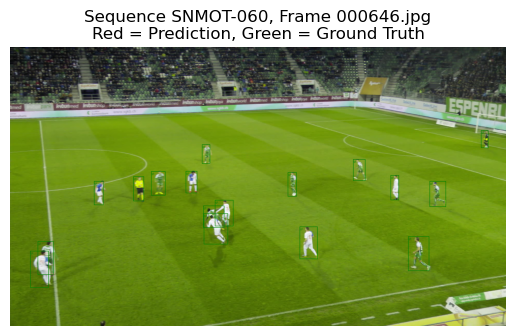

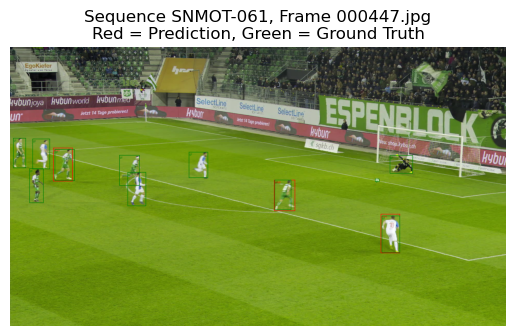

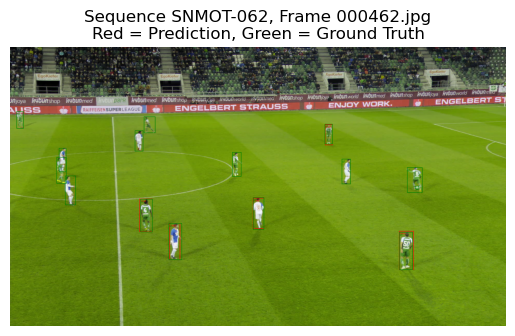

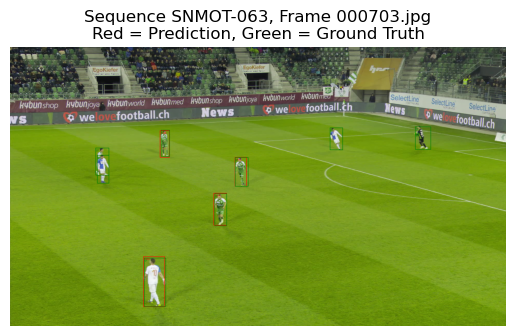

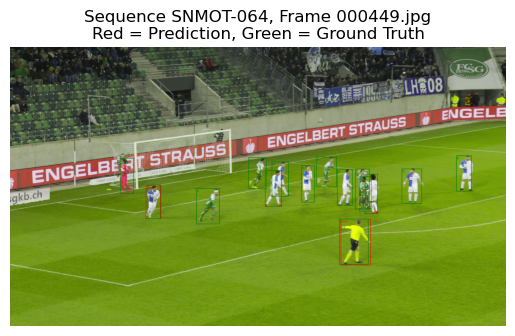

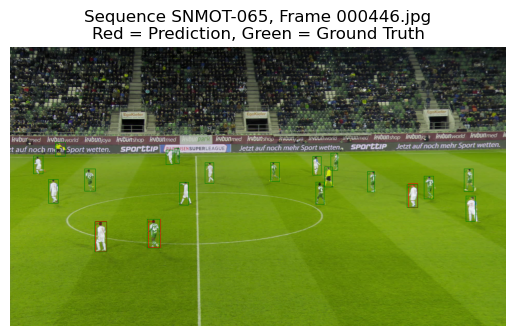

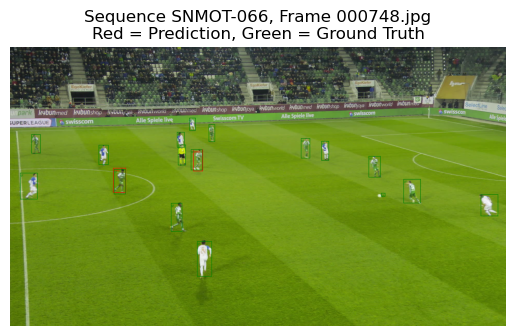

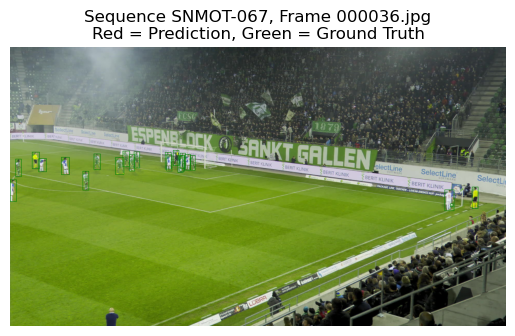

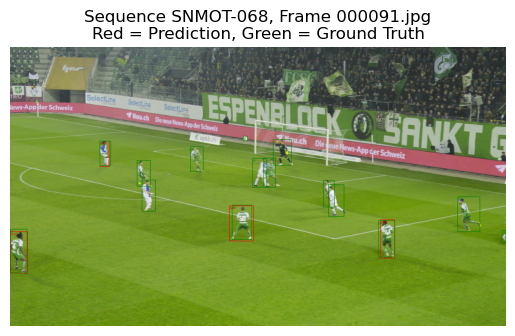

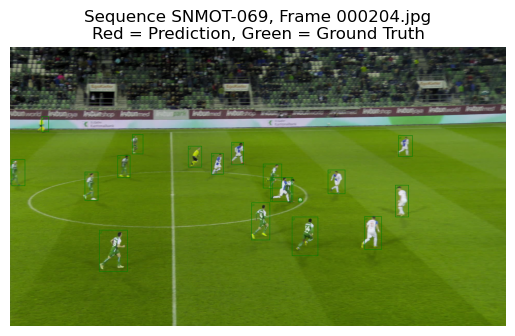

In [7]:


# --- LOAD MODEL ---
model = YOLO("yolo11n.pt").to(DEVICE)
# model.half()
# model.to(DEVICE)

transform = T.ToTensor()

def load_gt_boxes(gt_path):
    gt_dict = defaultdict(list)
    if not os.path.exists(gt_path):
        return gt_dict
    with open(gt_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            frame, _, x, y, w, h, cls, _, _ = map(int, parts[:9])
            gt_dict[frame].append(torch.tensor([x, y, x + w, y + h], device=DEVICE))
    return gt_dict

def compute_iou(box1, box2):
    if box1.size(0) == 0 or box2.size(0) == 0:
        return torch.zeros((box1.size(0), box2.size(0)), device=box1.device)
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    lt = torch.max(box1[:, None, :2], box2[:, :2])
    rb = torch.min(box1[:, None, 2:], box2[:, 2:])
    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]
    union = area1[:, None] + area2 - inter
    iou = inter / union
    return iou

def plot_gt_and_detections(image_tensor, detections, gt_boxes):
    from torchvision.utils import draw_bounding_boxes
    all_boxes = []
    labels = []
    colors = []

    for box in detections:
        all_boxes.append(box)
        labels.append("pred")
        colors.append("red")

    for box in gt_boxes:
        all_boxes.append(box)
        labels.append("gt")
        colors.append("green")

    if not all_boxes:
        return T.ToPILImage()(image_tensor)
    
    boxes_tensor = torch.stack(all_boxes).cpu()

    
    x1 = torch.min(boxes_tensor[:, 0], boxes_tensor[:, 2])
    y1 = torch.min(boxes_tensor[:, 1], boxes_tensor[:, 3])
    x2 = torch.max(boxes_tensor[:, 0], boxes_tensor[:, 2])
    y2 = torch.max(boxes_tensor[:, 1], boxes_tensor[:, 3])
    boxes_tensor = torch.stack([x1, y1, x2, y2], dim=1).to(torch.int)
    img_uint8 = (image_tensor * 255).byte().cpu()
    drawn = draw_bounding_boxes(img_uint8, boxes_tensor, labels=labels, colors=colors, width=2)
    return T.ToPILImage()(drawn)

# --- EXECUTION ---
results = []
sample_frames = []
total_tp = total_fp = total_fn = 0

seq_dirs = []
for split in ["train", "test"]:
    split_dir = os.path.join(BASE_DATA_ROOT, split)
    if not os.path.exists(split_dir):
        continue
    for d in sorted(os.listdir(split_dir)):
        full_path = os.path.join(split_dir, d)
        if os.path.isdir(full_path):
            seq_dirs.append((split, d))

print("Using device:", DEVICE)
print("Processing sequences...")

for split, seq_id in tqdm(seq_dirs, desc="Sequences", dynamic_ncols=True):
    seq_path = os.path.join(BASE_DATA_ROOT, split, seq_id)
    img_dir = os.path.join(seq_path, IMAGE_FOLDER)
    gt_path = os.path.join(seq_path, "gt", GT_FILENAME)
    gt_dict = load_gt_boxes(gt_path)

    if not os.path.exists(img_dir):
        continue

    all_img_paths = sorted([
        os.path.join(img_dir, file)
        for file in os.listdir(img_dir)
        if any(file.lower().endswith(ext) for ext in IMAGE_EXTS)
    ])

    random.shuffle(all_img_paths)
    all_img_paths = all_img_paths[:SAMPLE_PER_SEQ]

    for path in all_img_paths:
        try:
            img = Image.open(path).convert("RGB")
        except:
            continue

        img_tensor = transform(img).unsqueeze(0)
        img_tensor = img_tensor.half()
        img_tensor = img_tensor.squeeze(0) 

        img_tensor = img_tensor.to(DEVICE)



        filename = os.path.basename(path)
        try:
            frame_id = int(filename.split('.')[0])
        except:
            continue

        gt_boxes = gt_dict.get(frame_id, [])

        with torch.no_grad():
            yolo_result = model(img)[0]  # Get first result
            preds = yolo_result.boxes.data.to(DEVICE) if yolo_result.boxes is not None else torch.empty((0, 6)).to(DEVICE)

        pred_boxes = preds[:, :4][preds[:, 4] > SCORE_THRESH] if len(preds) else torch.empty((0, 4), device=DEVICE)

        # Accuracy
        if gt_boxes:
            gt_tensor = torch.stack(gt_boxes).to(DEVICE)
            if len(pred_boxes) > 0:
                ious = compute_iou(pred_boxes, gt_tensor)
                max_ious = ious.max(dim=1)[0]
                acc = (max_ious > IOU_THRESH).float().mean().item()
            else:
                acc = 0.0
        else:
            acc = 1.0 if len(pred_boxes) == 0 else 0.0

        results.append(acc)

        # Precision/Recall
        matched_gt = set()
        tp = fp = 0
        if len(pred_boxes) > 0 and len(gt_boxes) > 0:
            ious = compute_iou(pred_boxes, gt_tensor)
            for i in range(len(pred_boxes)):
                max_iou, gt_idx = ious[i].max(0)
                if max_iou > IOU_THRESH and gt_idx.item() not in matched_gt:
                    tp += 1
                    matched_gt.add(gt_idx.item())
                else:
                    fp += 1
        else:
            tp = 0
            fp = len(pred_boxes)

        fn = len(gt_boxes) - len(matched_gt)
        total_tp += tp
        total_fp += fp
        total_fn += fn

        if len(sample_frames) < NUM_VISUALS and seq_id not in [s[0] for s in sample_frames]:
            img_vis = plot_gt_and_detections(img_tensor, pred_boxes, gt_boxes)
            sample_frames.append((seq_id, filename, img_vis))
            

# --- METRICS ---
precision = total_tp / (total_tp + total_fp + 1e-6)
recall = total_tp / (total_tp + total_fn + 1e-6)
avg_acc = sum(results) / len(results) if results else 0
print(f"\nAverage Detection Accuracy over {len(results)} frames: {avg_acc * 100:.2f}%")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}")

# --- SHOW EXAMPLES ---
for seq_id, filename, img in sample_frames:
    plt.imshow(img)
    plt.title(f"Sequence {seq_id}, Frame {filename}\nRed = Prediction, Green = Ground Truth")
    plt.axis("off")
    plt.show()
